In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib: {}'.format(matplotlib.__version__))

import seaborn as sns
print('Seaborn %s' % sns.__version__)

import plotly
import plotly.express as px
import plotly.graph_objects as go
print("plotly version: {}". format(plotly.__version__))
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Matplotlib: 3.4.2
Seaborn 0.11.1
plotly version: 5.1.0


/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [2]:
# read in competition data
df_train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

### Statistical Analysis of the anonymized features
part of the code is originally from: https://www.kaggle.com/astashiro/tps-aug2021-01pycaret-shap

In [3]:
df_train.corr()

id        f0        f1        f2        f3        f4        f5  \
id    1.000000  0.000625  0.000333  0.000876 -0.000328  0.001605 -0.001489   
f0    0.000625  1.000000 -0.004339 -0.004808  0.004662  0.001170  0.012141   
f1    0.000333 -0.004339  1.000000 -0.005421  0.000400 -0.002447  0.012614   
f2    0.000876 -0.004808 -0.005421  1.000000 -0.007057 -0.004661 -0.015663   
f3   -0.000328  0.004662  0.000400 -0.007057  1.000000 -0.003316  0.003605   
...        ...       ...       ...       ...       ...       ...       ...   
f96   0.001217 -0.003691 -0.010261  0.006028 -0.001366 -0.003439  0.000586   
f97   0.007288  0.000916  0.001508 -0.007387 -0.000912 -0.000765 -0.010183   
f98   0.003547 -0.005810 -0.009793  0.007708  0.001084  0.007636 -0.008550   
f99   0.001189  0.010797 -0.002633  0.001167  0.001137 -0.003666  0.009163   
loss  0.001020  0.008921  0.011847 -0.005064 -0.018853  0.005524  0.009387   

            f6        f7        f8  ...       f91       f92       f93  \
id   -0.002093  0.001868 -0.006448  ...  0.000919 -0.000568  0.003579   
f0    0.002686 -0.003814 -0.000343  ...  0.001487 -0.010135  0.006754   
f1   -0.001040 -0.004030 -0.014389  ... -0.004757 -0.005882  0.000846   
f2   -0.002435 -0.008019 -0.001225  ... -0.001910  0.028413 -0.001768   
f3    0.001931 -0.003344  0.006952  ... -0.001747 -0.002413 -0.003863   
...        ...       ...       ...  ...       ...       ...       ...   
f96  -0.006583 -0.003924  0.003426  ... -0.006034 -0.009362  0.002483   
f97   0.003493  0.010062 -0.003464  ...  0.001235  0.000920 -0.008840   
f98   0.003247  0.014759 -0.003924  ... -0.000962  0.000504 -0.011786   
f99  -0.002580  0.000896 -0.002488  ... -0.004707 -0.011619 -0.007215   
loss  0.005509  0.000762  0.007545  ... -0.001226 -0.009560 -0.006675   

           f94       f95       f96       f97       f98       f99      loss  
id    0.000276  0.000059  0.001217  0.007288  0.003547  0.001189  0.001020  
f0    0.000346  0.002566 -0.003691  0.000916 -0.005810  0.010797  0.008921  
f1    0.018600  0.003927 -0.010261  0.001508 -0.009793 -0.002633  0.011847  
f2   -0.007150 -0.010727  0.006028 -0.007387  0.007708  0.001167 -0.005064  
f3    0.007330  0.000234 -0.001366 -0.000912  0.001084  0.001137 -0.018853  
...        ...       ...       ...       ...       ...       ...       ...  
f96  -0.013192  0.000263  1.000000 -0.011481  0.005689 -0.001055 -0.020655  
f97  -0.003581 -0.004906 -0.011481  1.000000  0.003898  0.003154  0.003908  
f98  -0.011039 -0.000142  0.005689  0.003898  1.000000  0.002516  0.005806  
f99   0.007500 -0.002173 -0.001055  0.003154  0.002516  1.000000  0.007507  
loss  0.006649 -0.004756 -0.020655  0.003908  0.005806  0.007507  1.000000  

[102 rows x 102 columns]

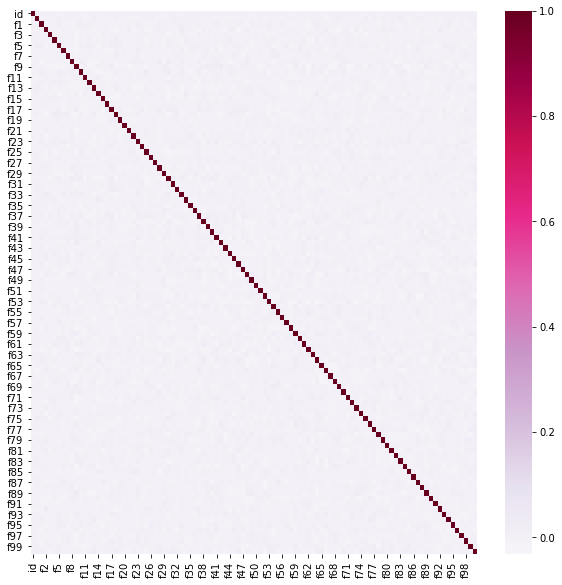

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),cmap='PuRd')
plt.show()

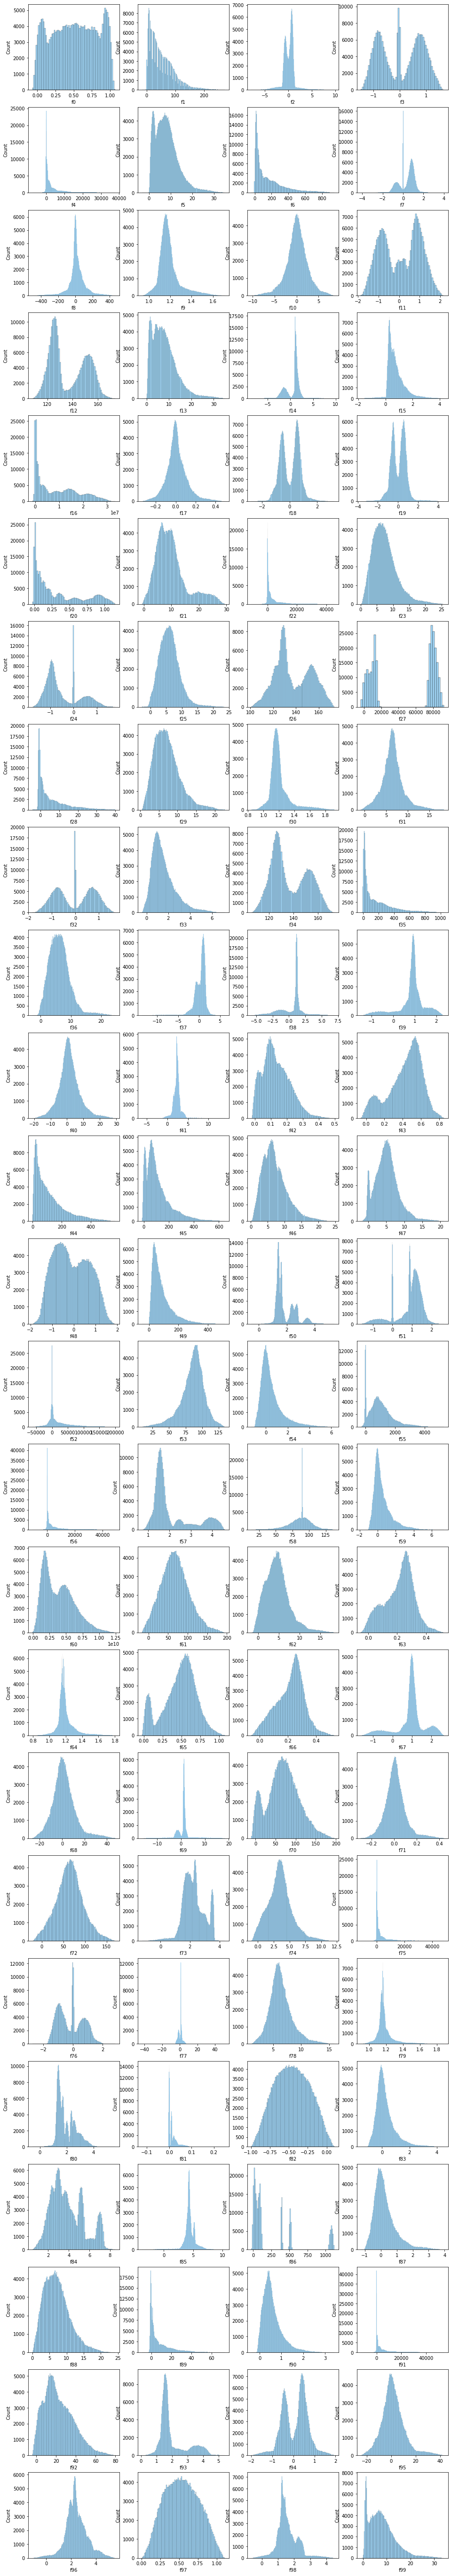

In [5]:
cols = df_train.columns.values
fig, ax = plt.subplots(25, 4, figsize=(16,100))
cnt = 0
for i in cols:
    if i == 'loss':
        break
    elif i == 'id':
        continue
    else:
        sns.histplot(df_train[i], ax=ax[cnt//4, cnt%4], color='lightskyblue')
        cnt += 1
    
plt.show()

<AxesSubplot:ylabel='Frequency'>

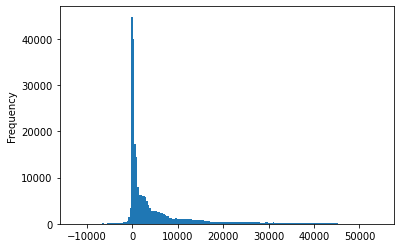

In [6]:
df_train.f91.plot(kind='hist', bins=200)

<AxesSubplot:xlabel='f91', ylabel='Count'>

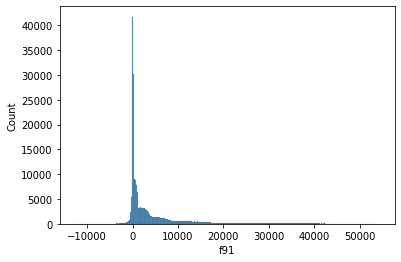

In [7]:
sns.histplot(data=df_train.f91)

In [8]:
bins = [-10000, -100, -10, 0, 10, 100,10000]
df_train['f91_bin'] = pd.cut(df_train.f91, bins)

In [9]:
df_train.f91_bin.value_counts()

(100, 10000]      140472
(10, 100]          25854
(-100, -10]        21302
(-10000, -100]     16511
(0, 10]             2948
(-10, 0]            2944
Name: f91_bin, dtype: int64

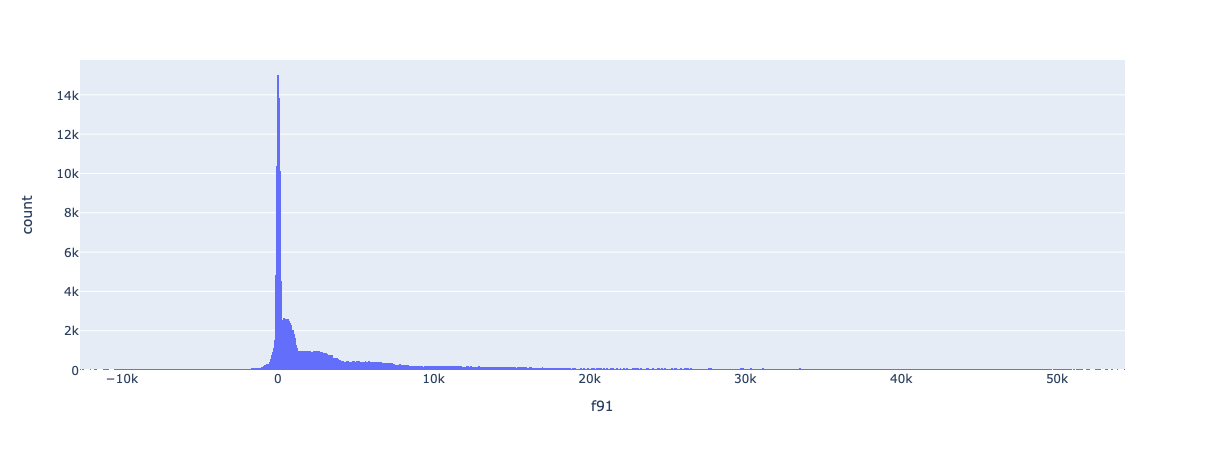

In [10]:
fig = px.histogram(df_train, x="f91", nbins=2000)

fig.show()

In [11]:
df_train.f91.describe()

count    250000.000000
mean       4856.812768
std        8501.609009
min      -12695.700000
25%          73.203100
50%        1060.025000
75%        5572.982500
max       54334.600000
Name: f91, dtype: float64

### Examining the effect of different preprocessing types on distributions
see also [sklearn summary page](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html?highlight=standard%20scaler)

In [12]:
df_train_reduced= df_train[df_train.columns[1:5]]
df_train_reduced.head()

f0   f1        f2        f3
0 -0.002350   59  0.766739 -1.350460
1  0.784462  145 -0.463845 -0.530421
2  0.317816   19 -0.432571 -0.382644
3  0.210753   17 -0.616454  0.946362
4  0.439671   20  0.968126 -0.092546

In [27]:
def plot_histograms(df,title):
    # attention will not work yet if more than 4 plots shall be made, error in ax=[dim1,dim2]
    # only tested for 4 plots
    cols=df.columns.values
    fig, ax = plt.subplots(len(cols)//4, 4, figsize=(20,len(cols)))
    fig.suptitle(title)
    cnt = 0
    for column in cols:
        sns.histplot(df[column], ax=ax[cnt%4])
        cnt += 1
    return


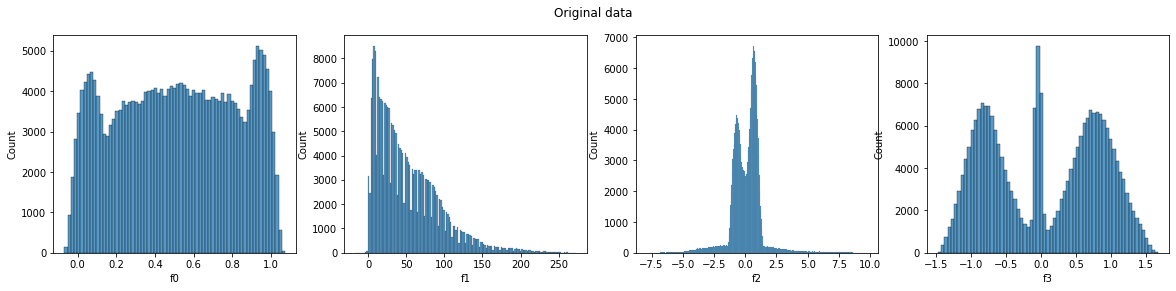

In [28]:
plot_histograms(df_train_reduced, "Original data")

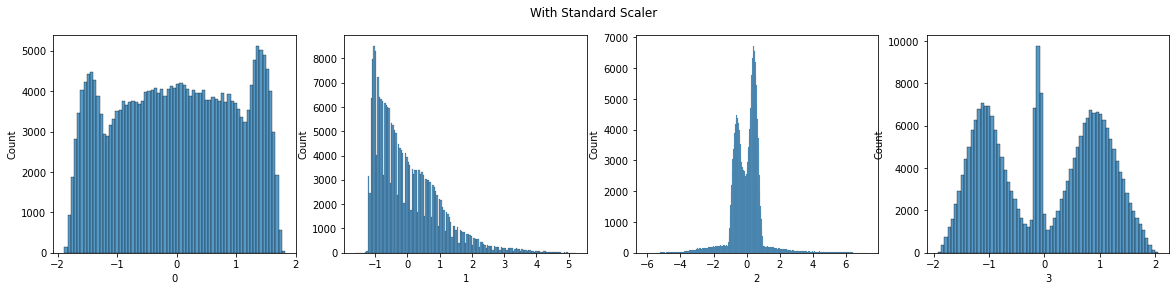

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_reduced_ss = pd.DataFrame(scaler.fit_transform(df_train_reduced))

plot_histograms(df_train_reduced_ss, "With Standard Scaler")

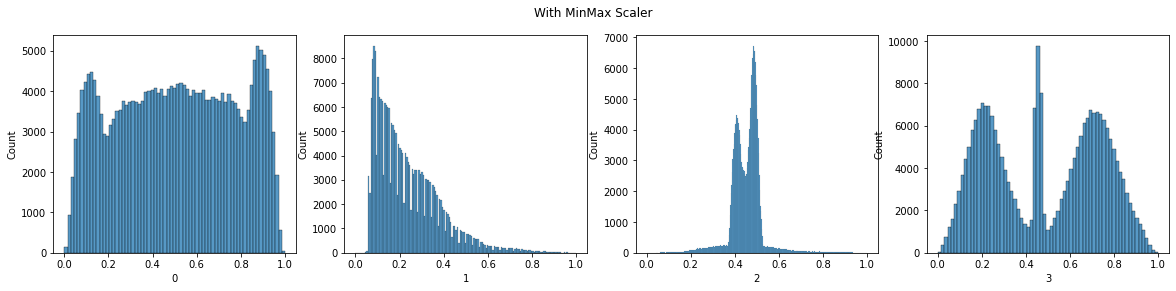

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train_reduced_mm = pd.DataFrame(scaler.fit_transform(df_train_reduced))

plot_histograms(df_train_reduced_mm, "With MinMax Scaler")

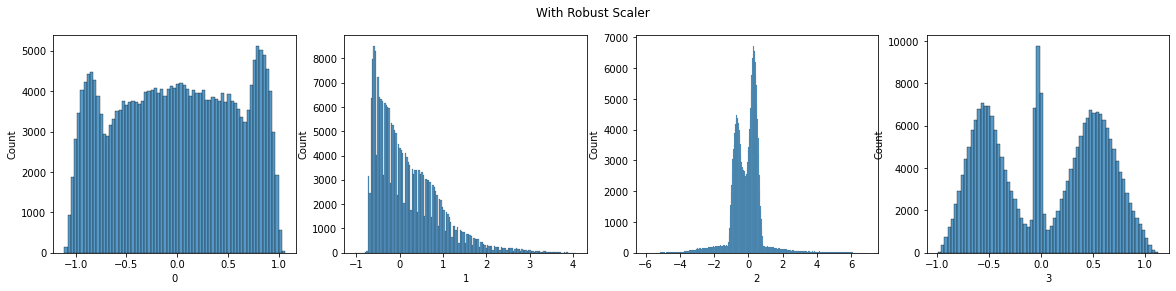

In [31]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_train_reduced_rs = pd.DataFrame(scaler.fit_transform(df_train_reduced))

plot_histograms(df_train_reduced_rs, "With Robust Scaler")

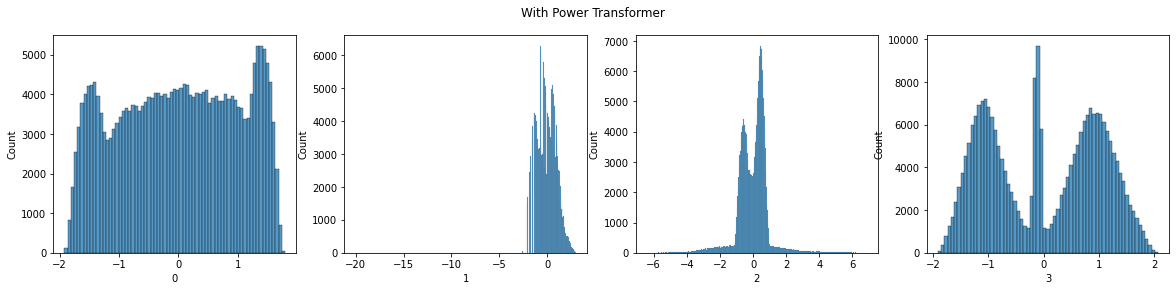

In [32]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
df_train_reduced_pt = pd.DataFrame(transformer.fit_transform(df_train_reduced))

plot_histograms(df_train_reduced_pt, "With Power Transformer")

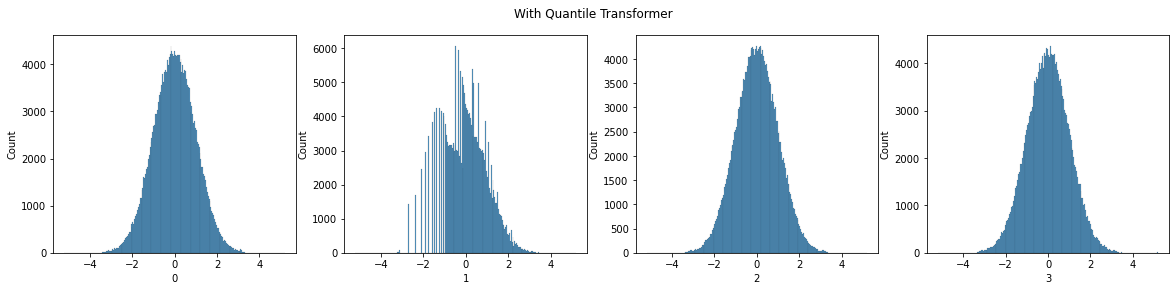

In [33]:
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(output_distribution = 'normal')
df_train_reduced_qt = pd.DataFrame(transformer.fit_transform(df_train_reduced))

plot_histograms(df_train_reduced_qt, "With Quantile Transformer")